#### Training a Linear Neural Network and trying to see if it can perform well in an image classification task.


In [42]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [43]:
def read_and_decode(filename, resize_dims):
    # 1. Reads raw file content (bytes) from the given file path
    img_bytes = tf.io.read_file(filename)
    # 2. Decodes JPEG image into a TensorFlow image tensor with 3 channels (RGB).
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    # 3. Converts pixel values from [0, 255] integers to [0.0, 1.0] float32.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resizes image to target size (224x224).
    img = tf.image.resize(img, resize_dims)
    return img

In [44]:
def parse_csvline(csv_line):
    # Tells TensorFlow that CSV lines have two string fields.
    record_default = ["", ""]
    # Splits the line into two variables: filename and label_string.
    filename, label_string = tf.io.decode_csv(csv_line, record_default)

    # Reads and processes the image file.
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

    # Converts string label like "roses" into its index (2 for "roses").
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

In [45]:
# Defining training and evaluation set datasets and the images will be returned in a batch of 16
train_dataset = (
    # Reads the CSV file, one line at a time.
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    # Applies parse_csvline() function to each line → returns (image, label).
    # AUTOTUNE allows TensorFlow to decide the optimal number of threads for mapping and prefetching
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    # Prefetches batches to improve performance during training.
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [46]:
for image_batch, label_batch in train_dataset.take(3):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1 0 3 2 1 0 4 2 0 2 2 1 3 3 2 1 0]
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Labels: [3 1 1 1 1 0 1 2 4 3 3 2 0 1 4 0 0 3 2 3 0 4 1 0 4 4 0 3 2 3 2 3]
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Labels: [4 3 1 2 2 0 3 3 3 4 2 0 3 4 2 2 0 4 0 4 1 3 4 0 4 1 0 4 1 0 4 3]


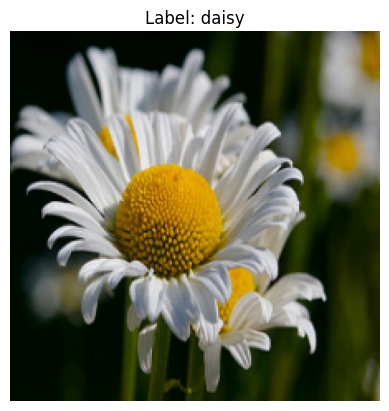

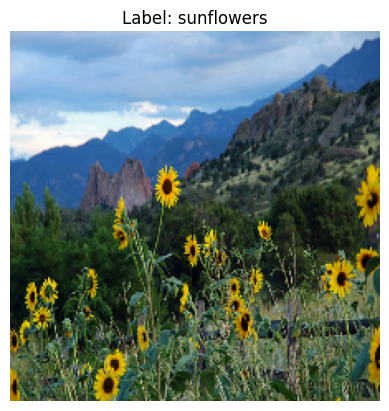

In [47]:
for image_batch, label_batch in train_dataset.take(2):
    # Take the first image from the batch
    first_image = image_batch[0]
    first_label = label_batch[0]

    # Convert tensor to numpy array
    plt.imshow(first_image.numpy())
    plt.title(f"Label: {CLASS_NAMES[first_label]}")
    plt.axis('off')
    plt.show()

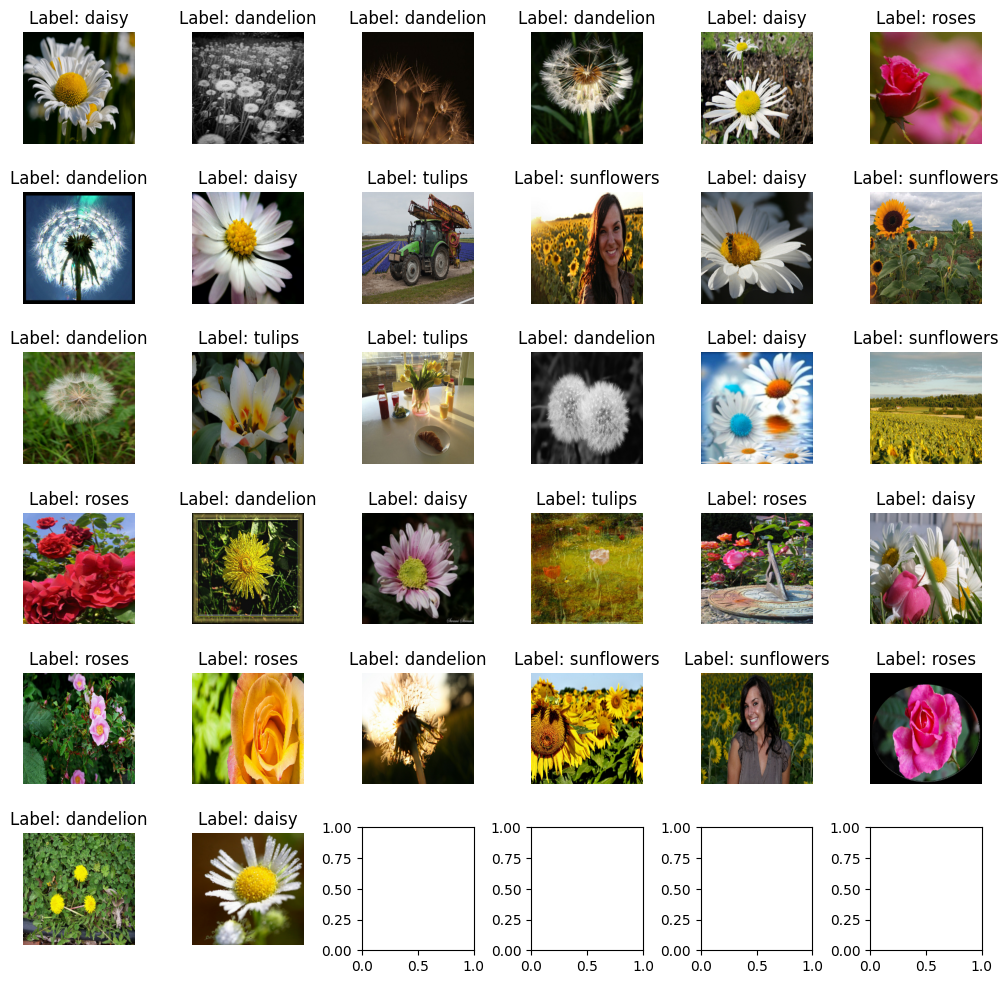

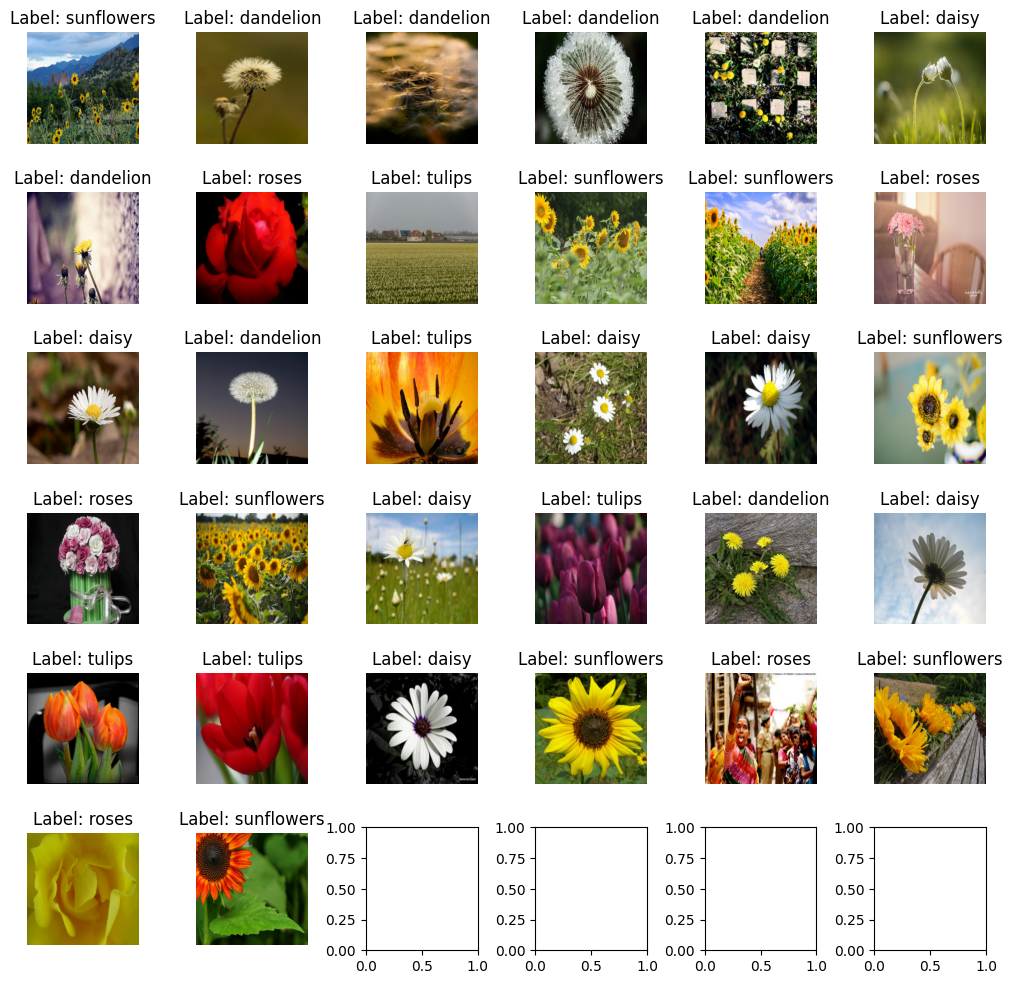

In [52]:
# Take two batch from the dataset
for image_batch, label_batch in train_dataset.take(2):
    fig, axes = plt.subplots(6, 6, figsize=(10, 10))  # Create a 4x4 grid

    for i in range(32):  # Loop over the first 32 images
        ax = axes[i // 6, i % 6]  # Determine grid position
        ax.imshow(image_batch[i].numpy())  # Convert tensor to numpy array
        ax.set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
        ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()


In [53]:
model = keras.Sequential([
    # Convert the images to a 1D vector
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
EPOCHS = 5

history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCHS,
)

Epoch 1/5
    104/Unknown 83s 773ms/step - accuracy: 0.2961 - loss: 27.3877

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


104/104 ━━━━━━━━━━━━━━━━━━━━ 94s 885ms/step - accuracy: 0.2964 - loss: 27.2750 - val_accuracy: 0.3243 - val_loss: 9.2120
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 100s 959ms/step - accuracy: 0.3889 - loss: 9.0664 - val_accuracy: 0.2622 - val_loss: 13.2588
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 957ms/step - accuracy: 0.4083 - loss: 9.1161 - val_accuracy: 0.2811 - val_loss: 11.9378
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 132s 865ms/step - accuracy: 0.4503 - loss: 7.7098 - val_accuracy: 0.2892 - val_loss: 9.8648
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 861ms/step - accuracy: 0.4166 - loss: 7.8993 - val_accuracy: 0.4324 - val_loss: 9.5839


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


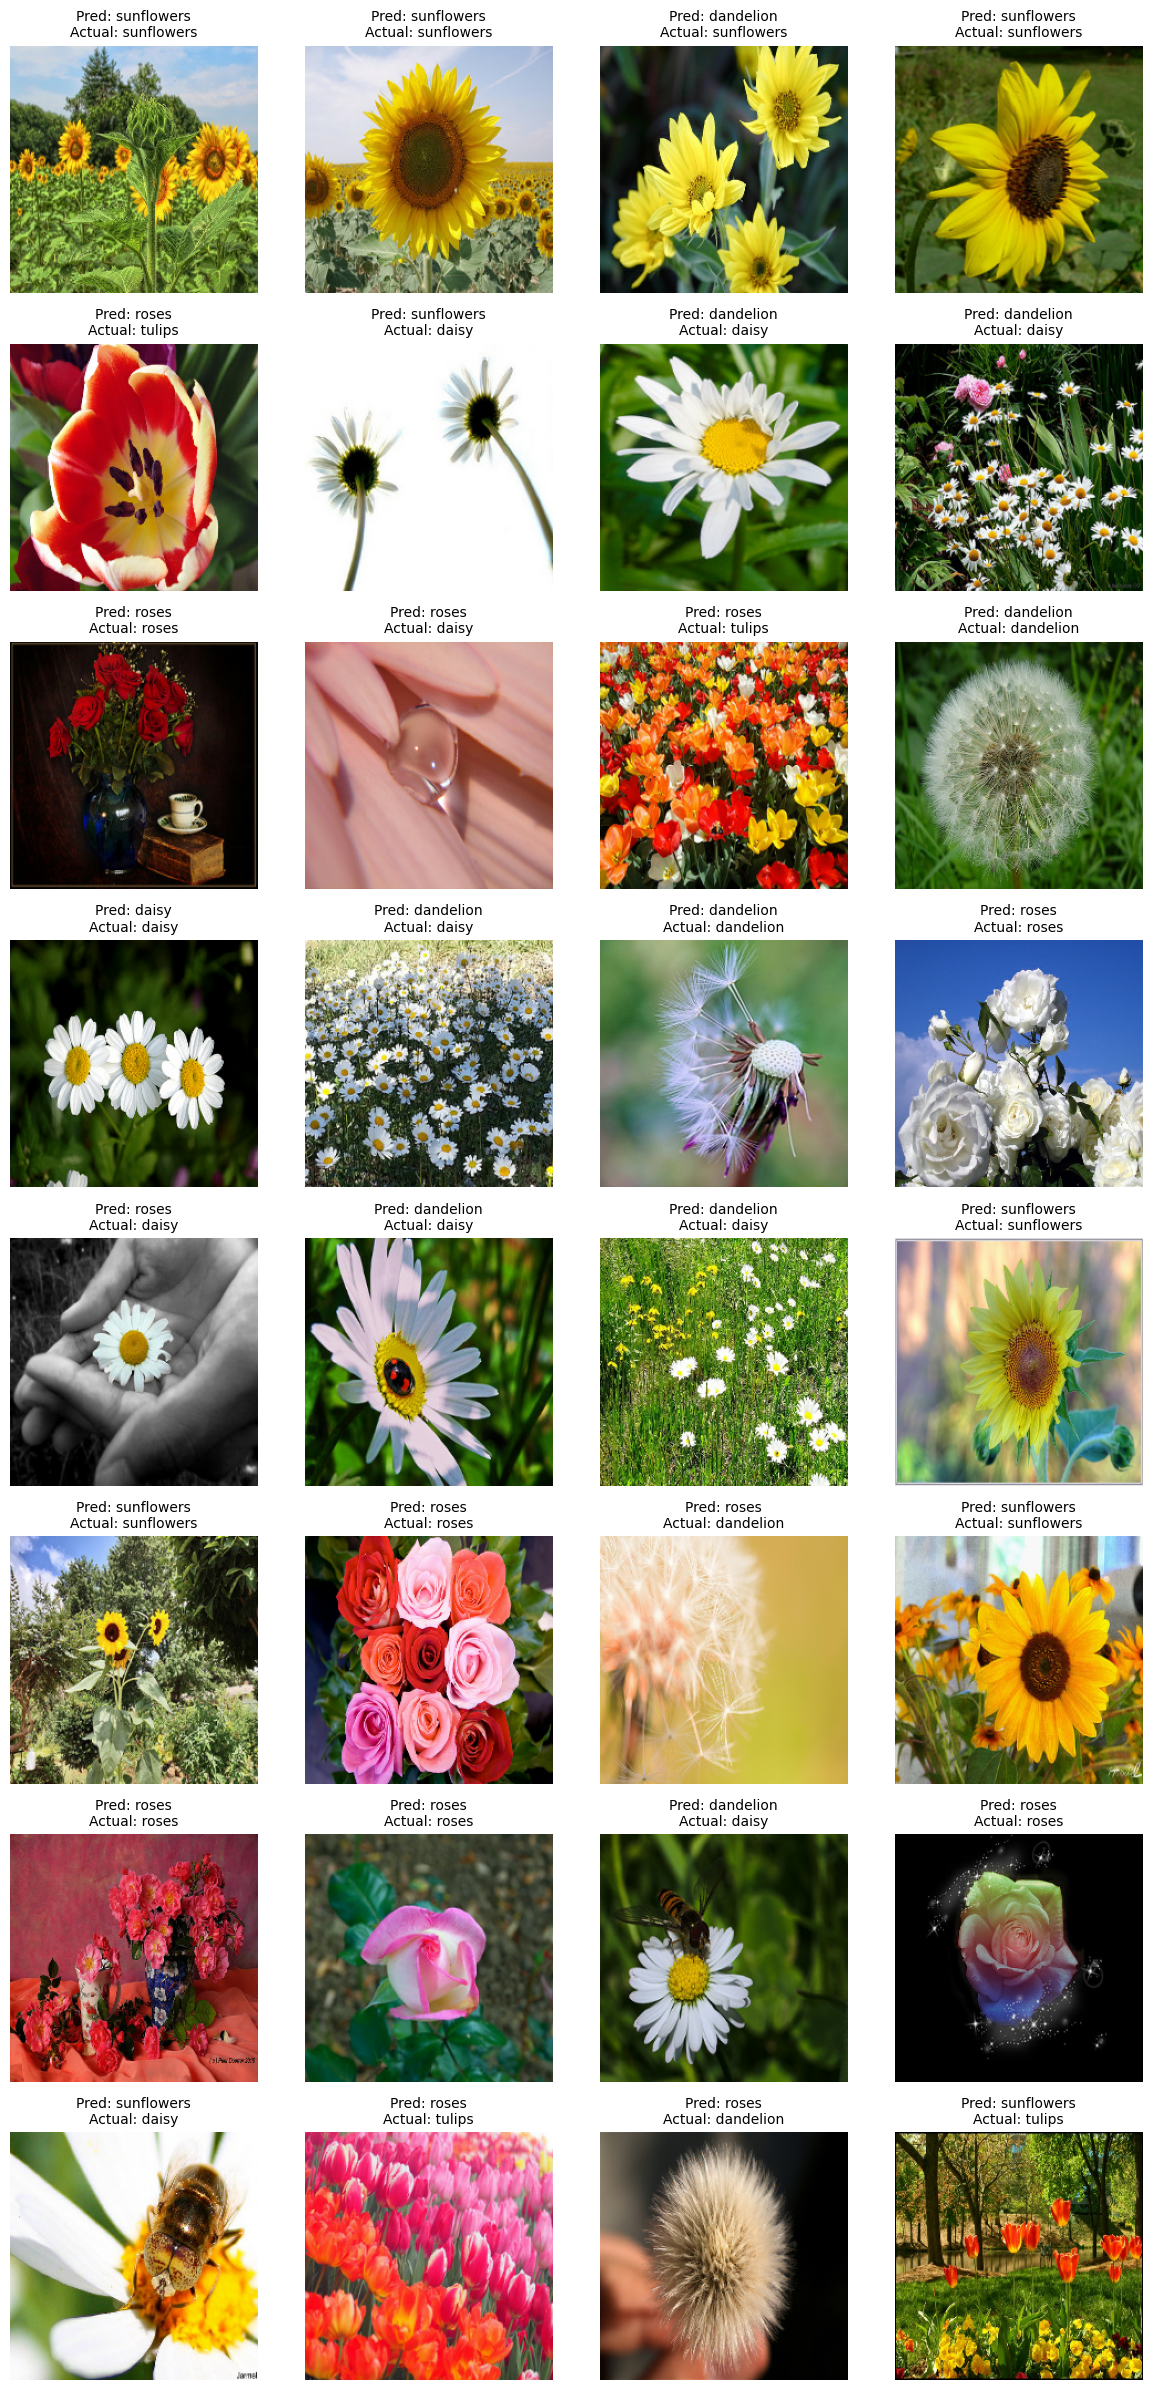

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Take exactly one batch from the evaluation dataset
for images, labels in eval_dataset.take(1):
    # Get model predictions for this batch
    batch_predictions = model.predict(images)
    predicted_indices = np.argmax(batch_predictions, axis=1)

    # Number of images in this batch
    num_images = images.shape[0]

    # Configure how many images to display per row
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure with a suitable size
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get predicted and actual class names
        pred_class = CLASS_NAMES[predicted_indices[i]]
        actual_class = CLASS_NAMES[labels[i].numpy()]

        # Show both predicted and actual labels as title
        plt.title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=10)

    # Adjust spacing to avoid overlapping titles, etc.
    plt.tight_layout()
    plt.show()

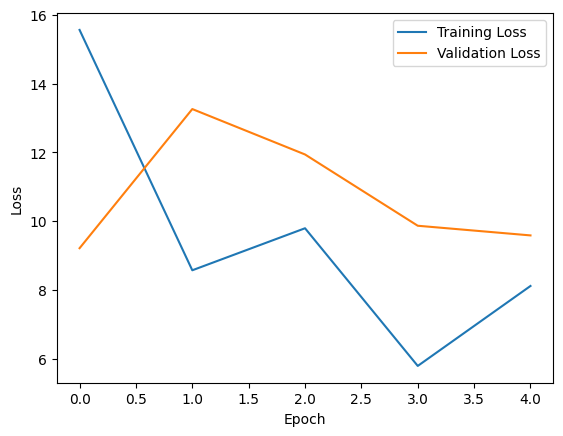

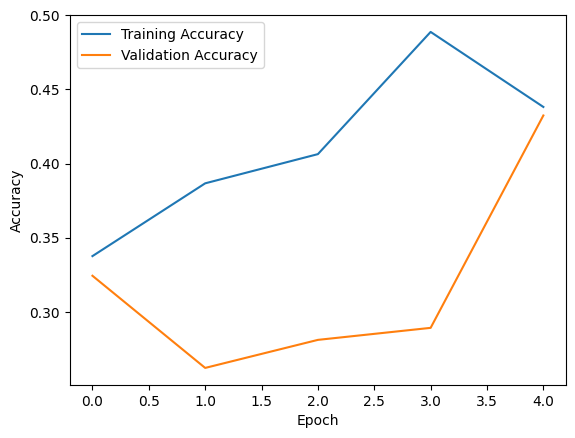

In [56]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Using just a linear neural network without any convolution filters we can achieve approx. 45% accuracy on the validation set which is atleast better than a random guess of 20% in our 5-class classification problem.